In [1]:
import pandas as pd
import numpy as np
import re #required for regular expressions
import copy
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import scipy.stats as stats

#Classifiers:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

scaler = MinMaxScaler()

In [2]:
#Sources:
#https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
#https://rstudio-pubs-static.s3.amazonaws.com/348904_1a80d04f436f4a41892179fbae1270c9.html

# Reading the data:

In [3]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_ids = test["PassengerId"]

data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Preprocessing the data:

## Extracting titles from the name column:

In [4]:
def addTitle(data):
    titles = []
    
    for i in range(len(data)):
        title = re.findall(r',\s*(.*?)\.',data.Name[i])[0]
        titles.append(title)
    data['title'] = titles
    frequency = data['title'].value_counts()
    frequency.plot(kind='bar')
    return data

train


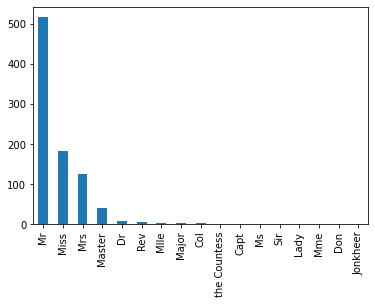

In [5]:
print('train')
data = addTitle(data)

test


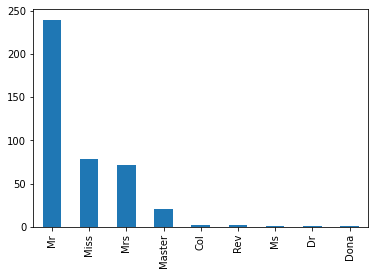

In [6]:
print('test')
test = addTitle(test)

## Counting NA values:

In [7]:
columns = test.columns
len(data)
for column in columns:
    print(column + ':\t\t' + str(data[column].isna().sum()) + '/891\t' + str(test[column].isna().sum()) + '/418')



PassengerId:		0/891	0/418
Pclass:		0/891	0/418
Name:		0/891	0/418
Sex:		0/891	0/418
Age:		177/891	86/418
SibSp:		0/891	0/418
Parch:		0/891	0/418
Ticket:		0/891	0/418
Fare:		0/891	1/418
Cabin:		687/891	327/418
Embarked:		2/891	0/418
title:		0/891	0/418


# Cleaning the data:

In [8]:
def custom_label_encoder(labels, mappings):
    encoded_labels = np.zeros(len(labels))
    for label, code in mappings.items():
        encoded_labels[labels == label] = code
    return encoded_labels

def changeTitle(title):
    if str(title) == "Mlle" or str(title) == "Mme":
        title = 'Miss'
    elif str(title) == 'Dona' or str(title) == 'Lady' or str(title) == 'Ms' or str(title) == 'the Countess':
        title = 'Mrs'
    elif str(title) == 'Major' or str(title) == 'Col' or str(title) == 'Capt':
        title = 'officer'
    elif str(title) == 'Jonkheer':
        title = 'Master'
    elif title == 'Sir' or title == 'Don':
        title = 'Mr'
    return title

In [9]:
def clean(data):
    
    #dropping uneeded columns:
    data = data.drop(["PassengerId","Name","Ticket","Cabin"], axis=1)
    
    #Encoding values of Sex column
    encoder = LabelEncoder()
    data['Sex'] = encoder.fit_transform(data['Sex'])
    
    #filling NA in column fare with median fare:
    data["Fare"].fillna(data["Fare"].median(), inplace=True)
    
    #filling NA in column age, so that it would be similarly distributed to already existing data:
    mean = data['Age'].mean()
    std = data['Age'].std()
    null_count = data['Age'].isnull().sum()
    samples = np.random.normal(loc=mean, scale=std, size=null_count)
    data.loc[data['Age'].isnull(), 'Age'] = samples
    
    #changing titles, to decrese dimensionality
    for i in range(len(data)):
        title = data.title[i]
        title = changeTitle(title)
        data.title[i] = title
    
    data = pd.concat([data, pd.get_dummies(data["title"])], axis=1)
    del data["title"]
    
    #I map mananualy the ports based on their order
    mappings = {'S':int('0'),'C':int('1'),'Q':int('2')}
    data.Embarked.fillna("C")
    data["Embarked"] = custom_label_encoder(data["Embarked"], mappings)
    
    return data

data = clean(data)
test = clean(test)

C:\Users\User\AppData\Local\Temp\ipykernel_14528\246295639.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.title[i] = title
C:\Users\User\AppData\Local\Temp\ipykernel_14528\246295639.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.title[i] = title


In [10]:
data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Dr,Master,Miss,Mr,Mrs,Rev,officer
0,0,3,1,22.000000,1,0,7.2500,0.0,0,0,0,1,0,0,0
1,1,1,0,38.000000,1,0,71.2833,1.0,0,0,0,0,1,0,0
2,1,3,0,26.000000,0,0,7.9250,0.0,0,0,1,0,0,0,0
3,1,1,0,35.000000,1,0,53.1000,0.0,0,0,0,0,1,0,0
4,0,3,1,35.000000,0,0,8.0500,0.0,0,0,0,1,0,0,0
5,0,3,1,51.039405,0,0,8.4583,2.0,0,0,0,1,0,0,0
6,0,1,1,54.000000,0,0,51.8625,0.0,0,0,0,1,0,0,0
7,0,3,1,2.000000,3,1,21.0750,0.0,0,1,0,0,0,0,0
8,1,3,0,27.000000,0,2,11.1333,0.0,0,0,0,0,1,0,0
9,1,2,0,14.000000,1,0,30.0708,1.0,0,0,0,0,1,0,0


# Scaling the data:

In [11]:
scaledData = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
scaledTest = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)


In [12]:
scaledData

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Dr,Master,Miss,Mr,Mrs,Rev,officer
0,0.0,1.0,1.0,0.416020,0.125,0.000000,0.014151,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.577118,0.125,0.000000,0.139136,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.456294,0.000,0.000000,0.015469,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.546912,0.125,0.000000,0.103644,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.546912,0.000,0.000000,0.015713,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0.5,1.0,0.466363,0.000,0.000000,0.025374,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
887,1.0,0.0,0.0,0.385814,0.000,0.000000,0.058556,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
888,0.0,1.0,0.0,0.411650,0.125,0.333333,0.045771,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
889,1.0,0.0,1.0,0.456294,0.000,0.000000,0.058556,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Data analysis:

## Correlations:

In [13]:
scaledData.corr(method = 'spearman')

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Dr,Master,Miss,Mr,Mrs,Rev,officer
Survived,1.000000,-0.339668,-0.543351,-0.009728,0.088879,0.138266,0.323736,0.135861,0.008185,0.079996,0.335636,-0.548524,0.347864,-0.064988,0.002496
Pclass,-0.339668,1.000000,0.135775,-0.264682,-0.043019,-0.022801,-0.688032,-0.004962,-0.107798,0.069727,-0.009714,0.142590,-0.169028,-0.048920,-0.109552
Sex,-0.543351,0.135775,1.000000,0.046239,-0.195204,-0.254512,-0.259593,-0.120400,0.039034,0.162017,-0.693916,0.871343,-0.555221,0.060741,0.055417
Age,-0.009728,-0.264682,0.046239,1.000000,-0.151948,-0.216697,0.093642,0.035162,0.075581,-0.290468,-0.203188,0.128311,0.167647,0.073560,0.113895
SibSp,0.088879,-0.043019,-0.195204,-0.151948,1.000000,0.450014,0.447113,-0.024673,0.003836,0.280659,0.026464,-0.302558,0.237422,-0.028728,-0.021349
Parch,0.138266,-0.022801,-0.254512,-0.216697,0.450014,1.000000,0.410074,-0.055119,-0.049399,0.355708,0.134617,-0.385642,0.192753,-0.017239,-0.010533
Fare,0.323736,-0.688032,-0.259593,0.093642,0.447113,0.410074,1.000000,-0.010172,0.063698,0.125935,0.085410,-0.326935,0.253327,0.008859,0.066899
Embarked,0.135861,-0.004962,-0.120400,0.035162,-0.024673,-0.055119,-0.010172,1.000000,0.030716,-0.023156,0.158175,-0.109030,-0.016983,-0.014021,-0.015350
Dr,0.008185,-0.107798,0.039034,0.075581,0.003836,-0.049399,0.063698,0.030716,1.000000,-0.019544,-0.045552,-0.105108,-0.036447,-0.007327,-0.006685
Master,0.079996,0.069727,0.162017,-0.290468,0.280659,0.355708,0.125935,-0.023156,-0.019544,1.000000,-0.112426,-0.259415,-0.089955,-0.018084,-0.016499


## Social status and survival rate:

<BarContainer object of 8 artists>

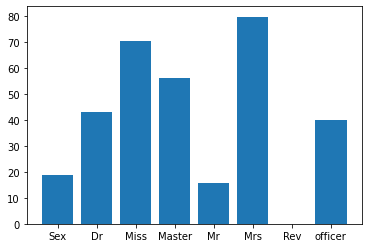

In [14]:
cols = ['Sex','Dr','Miss','Master','Mr','Mrs','Rev','officer']
survivalRates = []
for col in cols:
    counter1 = 0
    counterAll = 0
    for i in range(891):
        if scaledData[col][i] == 1:
            counterAll += 1
            if scaledData['Survived'][i] == 1:
                counter1+=1
    survivalRates.append(round(counter1/counterAll,3)*100)
    #print(col + ':\t' + str(round(counter1/counterAll,3)*100) + '% survived')
plt.bar(cols,survivalRates)

## Relatives and survival rate:

Text(0.5, 1.0, 'Parch')

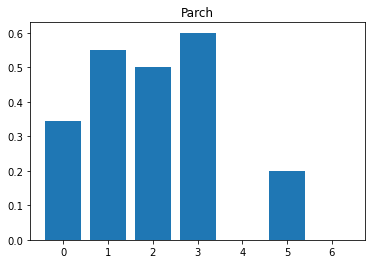

In [16]:
grouped = data.groupby('Parch')['Survived'].mean()
plt.bar(grouped.index, grouped)
plt.title('Parch')

Text(0.5, 1.0, 'relatives')

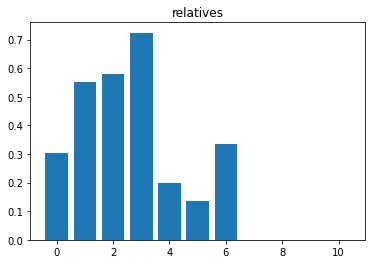

In [17]:
relatives = data['SibSp'] + data['Parch']
df = pd.DataFrame({'X': relatives, 'Y': data['Survived']})
grouped = df.groupby('X')['Y'].mean()
plt.bar(grouped.index, grouped)
plt.title('relatives')

Text(0.5, 1.0, 'relatives - hist')

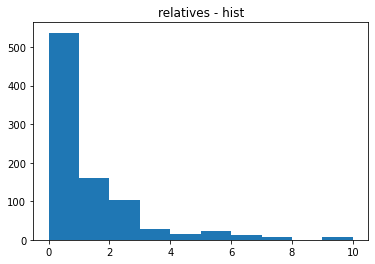

In [18]:
plt.hist(relatives)
plt.title('relatives - hist')

Text(0.5, 1.0, 'SibSp - hist')

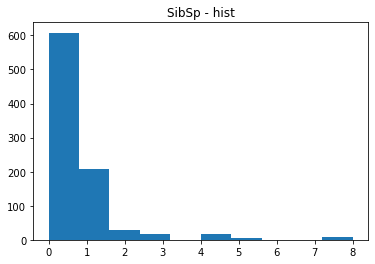

In [19]:
plt.hist(data['SibSp'])
plt.title('SibSp - hist')

Text(0.5, 1.0, 'Parch - hist')

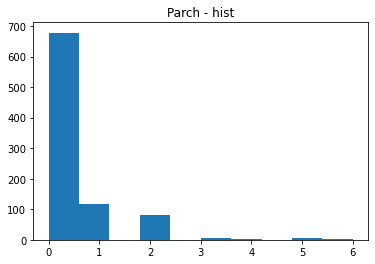

In [20]:
plt.hist(data['Parch'])
plt.title('Parch - hist')

## Fare and class:

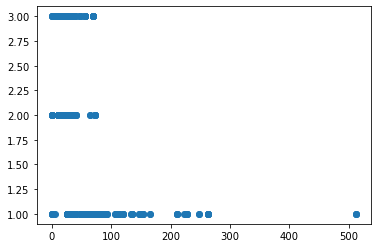

In [21]:
plt.scatter(data['Fare'],data['Pclass'])

Text(0.5, 1.0, 'Pclass')

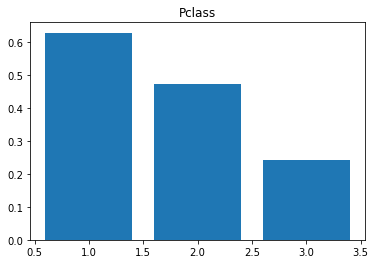

In [22]:
grouped = data.groupby('Pclass')['Survived'].mean()
plt.bar(grouped.index, grouped)
plt.title('Pclass')

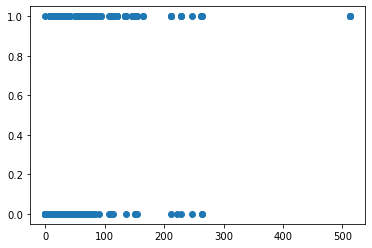

In [23]:
plt.scatter(data['Fare'],data['Survived'])

## Data preparation

In [24]:
def prepareData(data):
    ProffesionTitle = []
    for i in range(len(data)):
            if data['officer'][i] == 1 or data['Dr'][i]:
                ProffesionTitle.append(1)
            else:
                ProffesionTitle.append(0)

    data['ProffesionTitle'] = ProffesionTitle
    del data['officer']
    del data['Dr']
    
    relatives = data['SibSp'] + data['Parch']
    
    alone = []
    bigFamily = []
    
    for i in range(len(data)):
        if relatives[i] == 0:
            alone.append(1)
            bigFamily.append(0)
        elif relatives[i] > 3:
            alone.append(0)
            bigFamily.append(1)
        else:
            alone.append(0)
            bigFamily.append(0)
    del data['SibSp']
    del data['Parch']
    
    data['alone'] = alone
    data['bigFamily'] = bigFamily
    
    return pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

scaledTest = prepareData(test)
scaledData = prepareData(data)

# Correlation table again

In [25]:
scaledData.corr(method = 'spearman')

,Survived,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rev,ProffesionTitle,alone,bigFamily
Survived,1.000000,-0.339668,-0.543351,-0.009728,0.323736,0.135861,0.079996,0.335636,-0.548524,0.347864,-0.064988,0.007887,-0.203367,-0.125147
Pclass,-0.339668,1.000000,0.135775,-0.264682,-0.688032,-0.004962,0.069727,-0.009714,0.142590,-0.169028,-0.048920,-0.153562,0.135896,0.162003
Sex,-0.543351,0.135775,1.000000,0.046239,-0.259593,-0.120400,0.162017,-0.693916,0.871343,-0.555221,0.060741,0.065812,0.303646,-0.102954
Age,-0.009728,-0.264682,0.046239,1.000000,0.093642,0.035162,-0.290468,-0.203188,0.128311,0.167647,0.073560,0.131701,0.144730,-0.175668
Fare,0.323736,-0.688032,-0.259593,0.093642,1.000000,-0.010172,0.125935,0.085410,-0.326935,0.253327,0.008859,0.092143,-0.531472,0.251052
Embarked,0.135861,-0.004962,-0.120400,0.035162,-0.010172,1.000000,-0.023156,0.158175,-0.109030,-0.016983,-0.014021,0.013579,-0.011471,-0.090646
Master,0.079996,0.069727,0.162017,-0.290468,0.125935,-0.023156,1.000000,-0.112426,-0.259415,-0.089955,-0.018084,-0.025661,-0.259554,0.318882
Miss,0.335636,-0.009714,-0.693916,-0.203188,0.085410,0.158175,-0.112426,1.000000,-0.604638,-0.209665,-0.042149,-0.059811,-0.048054,0.110126
Mr,-0.548524,0.142590,0.871343,0.128311,-0.326935,-0.109030,-0.259415,-0.604638,1.000000,-0.483788,-0.097256,-0.138009,0.396263,-0.224633
Mrs,0.347864,-0.169028,-0.555221,0.167647,0.253327,-0.016983,-0.089955,-0.209665,-0.483788,1.000000,-0.033725,-0.047856,-0.360600,0.013747


In [26]:

#ProffesionTitle = []
#for i in range(418):
 #       if scaledTest['officer'][i] == 1 or scaledTest['Dr'][i]:
  #          ProffesionTitle.append(1)
   #     else:
    #        ProffesionTitle.append(0)
            
#scaledTest['ProffesionTitle'] = ProffesionTitle
#del scaledTest['officer']
#del scaledTest['Dr']

In [27]:
X = copy.deepcopy(scaledData)
del X['Survived']
X

,Pclass,Sex,Age,Fare,Embarked,Master,Miss,Mr,Mrs,Rev,ProffesionTitle,alone,bigFamily
0,1.0,1.0,0.416020,0.014151,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.577118,0.139136,0.5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.456294,0.015469,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.546912,0.103644,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.546912,0.015713,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.5,1.0,0.466363,0.025374,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
887,0.0,0.0,0.385814,0.058556,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
888,1.0,0.0,0.411650,0.045771,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
889,0.0,1.0,0.456294,0.058556,0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Using linear regression to find the most relevant columns:

In [28]:
lm = sm.OLS(scaledData['Survived'], sm.add_constant(X))
print(lm.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     61.10
Date:                Sat, 20 May 2023   Prob (F-statistic):          5.08e-107
Time:                        12:22:19   Log-Likelihood:                -351.52
No. Observations:                 891   AIC:                             729.0
Df Residuals:                     878   BIC:                             791.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9038      0.219     

In [29]:
olsX = X.drop(['Sex','Age','Fare','Embarked','ProffesionTitle','Master','bigFamily','alone','Rev'], axis=1)
lm = sm.OLS(scaledData['Survived'], sm.add_constant(olsX))
print(lm.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     140.5
Date:                Sat, 20 May 2023   Prob (F-statistic):           5.65e-93
Time:                        12:22:19   Log-Likelihood:                -403.17
No. Observations:                 891   AIC:                             816.3
Df Residuals:                     886   BIC:                             840.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6642      0.053     12.471      0.0

In [30]:
olsX = X.drop(['Sex','Embarked','Fare','Master','ProffesionTitle','bigFamily','Rev'], axis=1)
lm = sm.OLS(scaledData['Survived'], sm.add_constant(olsX))
print(lm.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     95.50
Date:                Sat, 20 May 2023   Prob (F-statistic):           1.84e-92
Time:                        12:22:19   Log-Likelihood:                -399.35
No. Observations:                 891   AIC:                             812.7
Df Residuals:                     884   BIC:                             846.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7585      0.069     11.070      0.0

In [31]:
olsX = X.drop(['Sex','Embarked','Fare','Master','ProffesionTitle','bigFamily'], axis=1)
lm = sm.OLS(scaledData['Survived'], sm.add_constant(olsX))
print(lm.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     84.41
Date:                Sat, 20 May 2023   Prob (F-statistic):           7.46e-94
Time:                        12:22:19   Log-Likelihood:                -393.72
No. Observations:                 891   AIC:                             803.4
Df Residuals:                     883   BIC:                             841.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7960      0.069     11.530      0.0

In [51]:
olsX = X.drop(['Sex','Embarked','Master','Fare','ProffesionTitle'], axis=1)
lm = sm.OLS(scaledData['Survived'], sm.add_constant(olsX))
print(lm.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     86.04
Date:                Sat, 20 May 2023   Prob (F-statistic):          4.07e-105
Time:                        12:34:32   Log-Likelihood:                -364.97
No. Observations:                 891   AIC:                             747.9
Df Residuals:                     882   BIC:                             791.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9189      0.069     13.360      0.0

In [33]:
scaledData = scaledData.drop(['Sex','Embarked','Fare','Master','ProffesionTitle'], axis=1)
scaledTest = scaledTest.drop(['Sex','Embarked','Fare','Master','ProffesionTitle'], axis=1)

In [34]:
#scaledData = scaledData.drop(['Sex','Embarked','Master','ProffesionTitle'], axis=1)
#scaledTest = scaledTest.drop(['Sex','Embarked','Master','ProffesionTitle'], axis=1)

In [35]:
scaledData

,Survived,Pclass,Age,Miss,Mr,Mrs,Rev,alone,bigFamily
0,0.0,1.0,0.416020,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.577118,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.456294,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.546912,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.546912,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
886,0.0,0.5,0.466363,0.0,0.0,0.0,1.0,1.0,0.0
887,1.0,0.0,0.385814,1.0,0.0,0.0,0.0,1.0,0.0
888,0.0,1.0,0.411650,1.0,0.0,0.0,0.0,0.0,0.0
889,1.0,0.0,0.456294,0.0,1.0,0.0,0.0,1.0,0.0


# Spliting a training set:

In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    scaledData.drop(['Survived'], axis=1),
    scaledData['Survived'],
    test_size=0.2, random_state=42)

# Random forest:

In [38]:
RandomForestModel = RandomForestClassifier(random_state=2137,n_estimators=2000, = 5)

## Hyperparameter tuning:

## Fitting the model:

In [41]:
def scores(target,prediction):
    cm = confusion_matrix(target, prediction)
    #N = dead
    #P = survived
    
    TN = cm[0,0]
    TP = cm[1,1]
    FP = cm[1,0]
    FN = cm[0,1]
    
    print("Accuracy = "+ str((TP+TN)/(TP+TN+FN+FP)))
    print("Recall (rate of survived people predicted as survived) = "+ str((TP)/(TP+FN)))
    print("Precission (how many people predicted as survived have actually survived) = "+ str((TP)/(TP+FP)))
    
    print(cm)

In [43]:
RandomForestModel = RandomForestClassifier(random_state=2137,
                                           n_estimators=2000,
                                           criterion='entropy',
                                           class_weight=None,
                                           Tji=5,
                                           min_samples_leaf = 5)

RandomForestModel.fit(X_train, y_train)
scores(y_val, RandomForestModel.predict(X_val))

predictionsRandomForestModel = RandomForestModel.predict(scaledTest)

Accuracy = 0.7932960893854749
Recall (rate of survived people predicted as survived) = 0.7681159420289855
Precission (how many people predicted as survived have actually survived) = 0.7162162162162162
[[89 16]
 [21 53]]


# Logistic regression:

In [44]:
LogisticRegressionModel = LogisticRegression(random_state=0,max_iter=1000)
LogisticRegressionModel.fit(X_train, y_train)
scores(y_val, LogisticRegressionModel.predict(X_val))

predictionsLogisticRegressionModel = LogisticRegressionModel.predict(scaledTest)

Accuracy = 0.7988826815642458
Recall (rate of survived people predicted as survived) = 0.7794117647058824
Precission (how many people predicted as survived have actually survived) = 0.7162162162162162
[[90 15]
 [21 53]]


# KNN:

In [45]:
KNNmodel = KNeighborsClassifier()

## Hyperparameter tuning:

In [46]:
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'minkowski']


param_grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)

grid = GridSearchCV(estimator=KNNmodel, 
                    param_grid=param_grid,
                    n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(grid_result.best_params_)
print(grid_result.best_score_)

{'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
0.828612232837585


In [47]:
KNNmodel = KNeighborsClassifier(metric='euclidean', n_neighbors = 11, weights = 'uniform')
KNNmodel.fit(X_train, y_train)
scores(y_val, KNNmodel.predict(X_val))

predictionsKNN = KNNmodel.predict(scaledTest)

Accuracy = 0.7988826815642458
Recall (rate of survived people predicted as survived) = 0.8166666666666667
Precission (how many people predicted as survived have actually survived) = 0.6621621621621622
[[94 11]
 [25 49]]


# Saving the submission file:

In [50]:
df = pd.DataFrame({
    "PassengerId":test_ids.values,
    "Survived":predictionsKNN.astype(int),
})
df.to_csv("submission.csv", index=False)